<a target="_blank" href="https://colab.research.google.com/github/BardiaKh/Mediffusion/blob/main/tutorials/02_2d_inpainting.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Inpainting with a Diffusion Model

Diffusion models are a group of Generative AI models that excell at image generation. In this tutorial we will use a diffusion model trained using [Mediffusion](https://github.com/BardiaKh/Mediffusion) package to inpaint certain areas of the image.

Before starting, we need to install the `Mediffusion` package:

In [ ]:
!pip install mediffusion -U

Then we import our packages:

In [2]:
import gdown
import os
import zipfile
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from mediffusion import DiffusionModule

2023-11-17 13:18:06,815 - Created a temporary directory at /tmp/tmp6ndtdu6d
2023-11-17 13:18:06,816 - Writing /tmp/tmp6ndtdu6d/_remote_module_non_scriptable.py
2023-11-17 13:18:06,816 - Writing /tmp/tmp6ndtdu6d/_remote_module_non_scriptable.py


In the next cell, we will download the weights of a trained model.

In [3]:
if not os.path.isdir("workshop_data"):
    os.mkdir("workshop_data")
    gdown.download(
        "https://drive.google.com/uc?export=download&confirm=pbef&id=1L_gKWO87A4qCL1H95yfMA3TmEwXjhtr8",
        "ddpm_weights.zip",
        quiet=False,
    )
    with zipfile.ZipFile("ddpm_weights.zip", 'r') as zip_ref:
        zip_ref.extractall("workshop_data")

    os.remove("ddpm_weights.zip")

First, let's test the model's performance:

In [4]:
model = DiffusionModule("./workshop_data/config.yaml")
model.load_ckpt("./workshop_data/last.ckpt", ema=True)
model.eval().cuda().half();

DDIM Sampling:   0%|          | 0/100 [00:00<?, ?it/s]

DDIM Sampling: 100%|██████████| 100/100 [00:03<00:00, 31.91it/s]


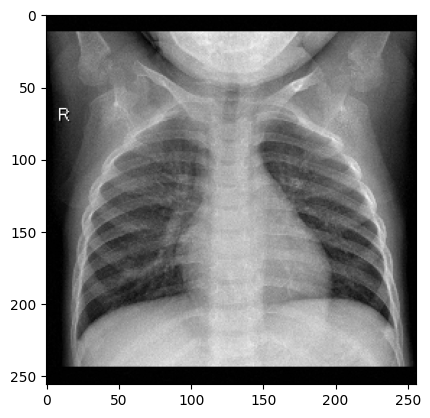

In [82]:
noise = torch.randn(1, 1, 256, 256)
cls_label = torch.tensor([0])       # 0: Normal, 1: Bacterial Pneumonia, 2: Viral Pneumonia

model_kwargs = {"cls": torch.nn.functional.one_hot(cls_label,num_classes=3)}

img = model.predict(
    noise,
    model_kwargs=model_kwargs,
    classifier_cond_scale=4,
    inference_protocol="DDIM100"
)

plt.imshow(img[0].permute(2, 1, 0).cpu().numpy(), cmap="gray")

Let's now create a mask which we want to use for inpainting:

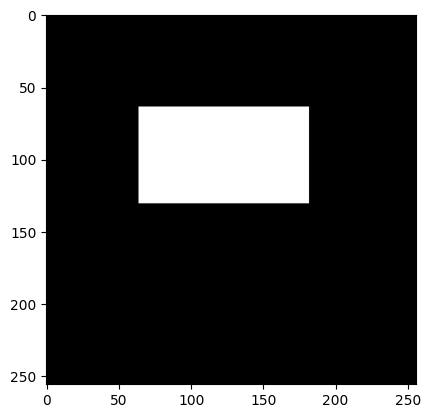

In [80]:
def create_random_masks(image_shape):
    mask = torch.zeros(image_shape, dtype=torch.uint8)
    num_squares = 1
    for _ in range(num_squares):
        mask_height = torch.randint(20, 150, (1,)).item()
        mask_width = torch.randint(20, 150, (1,)).item()

        mid_start_y, mid_end_y = image_shape[-2] // 4, image_shape[-2] * 3 // 4
        mid_start_x, mid_end_x = image_shape[-1] // 4, image_shape[-1] * 3 // 4

        max_y = min(mid_end_y - mask_height, mid_start_y)
        max_x = min(mid_end_x - mask_width, mid_start_x)

        x = torch.randint(mid_start_x, max_x, (1,)).item() if max_x > mid_start_x else mid_start_x
        y = torch.randint(mid_start_y, max_y, (1,)).item() if max_y > mid_start_y else mid_start_y

        mask[:, :, y:y + mask_height, x:x + mask_width] = 1
    return mask

mask = create_random_masks(noise.shape)
plt.imshow(mask[0].permute(2, 1, 0).cpu().numpy(), cmap="gray")

Let's use the generated image as our base image: 

In [83]:
original_img = img[0].clone().detach().unsqueeze(0)

Now let's inpaint the regions that are `1` in the mask region:

DDIM Sampling: 100%|██████████| 100/100 [00:03<00:00, 31.81it/s]


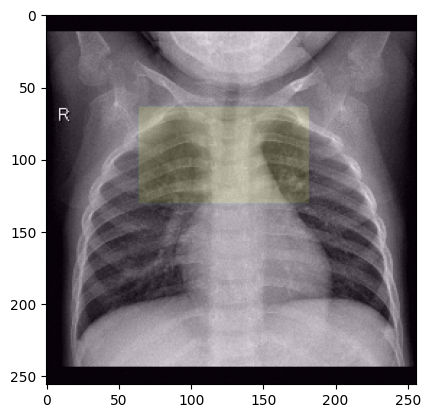

In [129]:
noise = torch.randn(1, 1, 256, 256)
cls_label = torch.tensor([0])

model_kwargs = {"cls": torch.nn.functional.one_hot(cls_label,num_classes=3)}

sample1 = model.predict(
    noise,
    model_kwargs=model_kwargs,
    classifier_cond_scale=4,
    inference_protocol="DDIM100",
    mask=mask,
    original_image=original_img,
)

plt.imshow(sample1[0].permute(2, 1, 0).cpu().numpy(), cmap="gray")
plt.imshow(mask[0].permute(2, 1, 0).cpu().numpy(), cmap="viridis", alpha=0.1)

Now let's compare the inpainted areas:

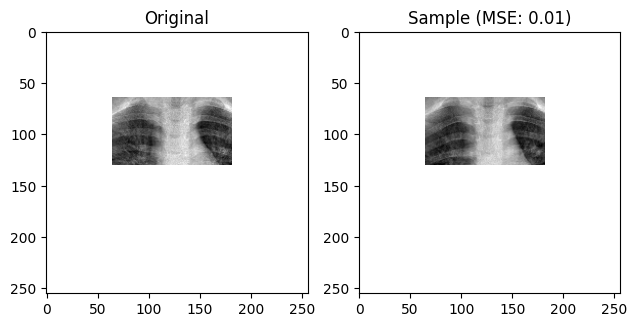

In [131]:
def plot_inpainted_areas(original_image, sample, mask):
    mask = mask.to(dtype=original_image.dtype)

    inpainted_area_original = original_image * mask
    inpainted_area_original[mask == 0] = float('nan')

    inpainted_area_sample = sample * mask
    inpainted_area_sample[mask == 0] = float('nan')

    non_nan_mask = ~torch.isnan(inpainted_area_original)
    non_nan_original = inpainted_area_original[non_nan_mask]
    non_nan_sample = inpainted_area_sample[non_nan_mask]
    mse_diff = torch.nn.functional.mse_loss(non_nan_original, non_nan_sample, reduction='mean')
    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(inpainted_area_original.permute(2, 1, 0).cpu().numpy(), cmap="gray")
    axs[0].set_title("Original")
    axs[1].imshow(inpainted_area_sample.permute(2, 1, 0).cpu().numpy(), cmap="gray")
    axs[1].set_title(f"Sample (MSE: {mse_diff:.2f})")
    plt.tight_layout()
    plt.show()

plot_inpainted_areas(original_img[0], sample1[0], mask[0])

Now, let's add some pneumonia to the inpainted region:

DDIM Sampling: 100%|██████████| 100/100 [00:03<00:00, 31.94it/s]


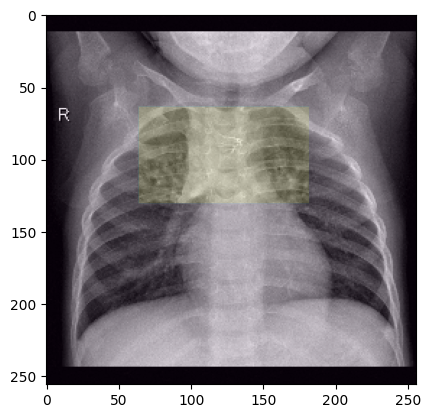

In [133]:
noise = torch.randn(1, 1, 256, 256)
cls_label = torch.tensor([1])
model_kwargs = {"cls": torch.nn.functional.one_hot(cls_label,num_classes=3)}

sample2 = model.predict(
    noise,
    model_kwargs=model_kwargs,
    classifier_cond_scale=4,
    inference_protocol="DDIM100",
    mask=mask,
    original_image=original_img,
)

plt.imshow(sample2[0].permute(2, 1, 0).cpu().numpy(), cmap="gray")
plt.imshow(mask[0].permute(2, 1, 0).cpu().numpy(), cmap="viridis", alpha=0.1)

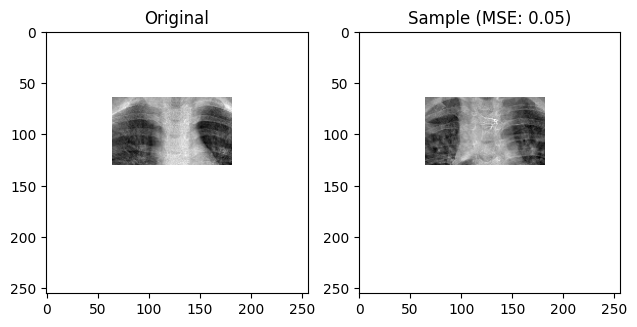

In [134]:
plot_inpainted_areas(original_img[0], sample2[0], mask[0])

Here is a side-by-side comparison of the generated images:

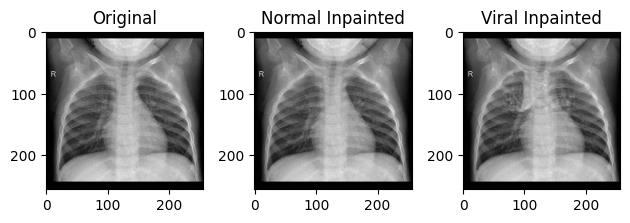

In [138]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(original_img[0].permute(2, 1, 0).cpu().numpy(), cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(sample1[0].permute(2, 1, 0).cpu().numpy(), cmap="gray")
axs[1].set_title("Normal Inpainted")
axs[2].imshow(sample2[0].permute(2, 1, 0).cpu().numpy(), cmap="gray")
axs[2].set_title("Bacterial Inpainted")
plt.tight_layout()
plt.show()

Hope you have enjoyed this tutorial! Checkout [Mediffusion repository](https://github.com/BardiaKh/Mediffusion) to learn more about what can be done with diffusion models!